### MNIST Demo using a Convolutional Neural Network

In [2]:
import torch
from torchvision import datasets, transforms

# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create the train dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the CNN model with input size 1 and output size 10
model = CNN(1, 10)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
from tqdm import tqdm

# Set the number of epochs
num_epochs = 10

# Train the model
for epoch in tqdm(range(num_epochs)):
    # Set the model to training mode
    model.train()
    
    # Initialize the total loss for the epoch
    total_loss = 0
    
    # Iterate over the training dataloader
    for images, labels in train_dataloader:
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the total loss
        total_loss += loss.item()
    
    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # Print the epoch number and loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


 10%|█         | 1/10 [00:24<03:40, 24.47s/it]

Epoch 1/10, Loss: 0.1582


 20%|██        | 2/10 [00:45<03:00, 22.52s/it]

Epoch 2/10, Loss: 0.0481


 30%|███       | 3/10 [01:07<02:36, 22.31s/it]

Epoch 3/10, Loss: 0.0318


 40%|████      | 4/10 [01:30<02:15, 22.63s/it]

Epoch 4/10, Loss: 0.0246


 50%|█████     | 5/10 [01:53<01:52, 22.55s/it]

Epoch 5/10, Loss: 0.0181


 60%|██████    | 6/10 [02:14<01:28, 22.15s/it]

Epoch 6/10, Loss: 0.0139


 70%|███████   | 7/10 [02:38<01:08, 22.82s/it]

Epoch 7/10, Loss: 0.0126


 80%|████████  | 8/10 [03:00<00:44, 22.44s/it]

Epoch 8/10, Loss: 0.0092


 90%|█████████ | 9/10 [03:21<00:21, 21.88s/it]

Epoch 9/10, Loss: 0.0088


100%|██████████| 10/10 [03:43<00:00, 22.33s/it]

Epoch 10/10, Loss: 0.0059


In [10]:
correct = 0
total = 0

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_dataloader:
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total number of samples
        total += labels.size(0)
        
        # Update the number of correct predictions
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total

print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.02%


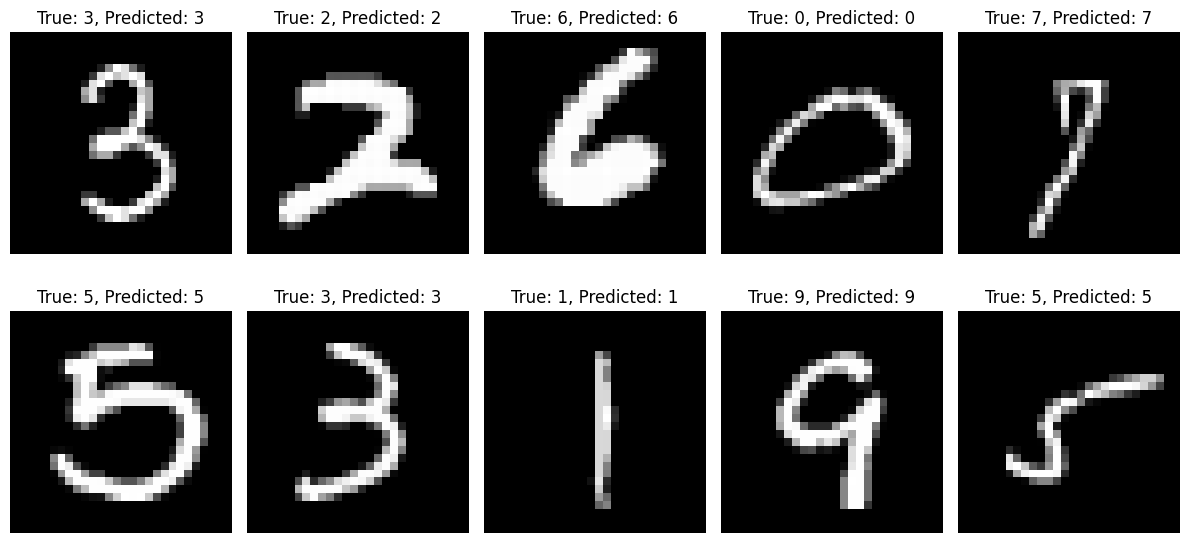

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get 10 random indices
random_indices = np.random.choice(len(test_dataset), size=10, replace=False)

# Get the corresponding images and labels
random_images = [test_dataset[i][0] for i in random_indices]
random_labels = [test_dataset[i][1] for i in random_indices]

# Set the model to evaluation mode
model.eval()

# Disable gradient calculation
with torch.no_grad():
    # Move the data to the device
    random_images = [image.to(device) for image in random_images]
    
    # Forward pass
    outputs = model(torch.stack(random_images))
    
    # Get the predicted labels
    _, predicted = torch.max(outputs.data, 1)

# Convert the tensors to numpy arrays
random_images = [image.cpu().numpy() for image in random_images]
predicted = predicted.cpu().numpy()

# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterate over the subplots and plot the images
for i, ax in enumerate(axes.flatten()):
    # Plot the image
    ax.imshow(random_images[i][0], cmap='gray')
    
    # Set the title with the true label and predicted class
    ax.set_title(f"True: {random_labels[i]}, Predicted: {predicted[i]}")
    
    # Remove the axis labels
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
